# Mean field VI code

Here, we code a mean-field variational approximation to discrete distributions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, time, pickle
from IPython.display import clear_output

sys.path.insert(1, '../../src/')
#from discrete_mixflows import *
#from gibbs import *
#from concrete import *
#from aux import *

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})
#fig_path='fig/'
#fig_path='../../../discrete-ergodic-flows-tex/fig/'

## Mean field 1D

First we deal with the case when the target distribution is univariate.
In this setting,
we simply optimize the individual probabilities via gradient descent.

In [2]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=10
prbs=np.random.rand(K1)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (1,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K1) array with d conditionals 
    
    ext_lprb=np.log(np.repeat(prbs[:,np.newaxis],x.shape[1],axis=1).T)
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x])
    return ext_lprb
prbs_onedim=np.copy(prbs)

In [3]:
########################
########################
#    mean field 1D     #
########################
########################
def meanfield1D(lq0,lp,max_iters,gamma):
    """
    Discrete mean field VI for 1D distributions
    
    Inputs:
        lq0       : (K,) array, initial variational log probabilities
        lp        : (K,) array, target log probabilities
        max_iters : int, max number of gradient ascent iterations
        gamma     : function, step size (as function)
    """
    q=np.exp(lq0)
    for t in range(max_iters): q=q-gamma(t)*(np.log(q)-lp)
    return np.log(q)

In [4]:
########################
########################
#  fit mean field 1D   #
########################
########################
lq0=np.log(1/K1)*np.ones(K1)
lp=np.log(prbs_onedim)
max_iters=10000
ss=1e-2
gamma = lambda t : ss/np.sqrt(t+1)
mf_approx=np.exp(meanfield1D(lq0,lp,max_iters,gamma))

Text(0, 0.5, 'Probability')

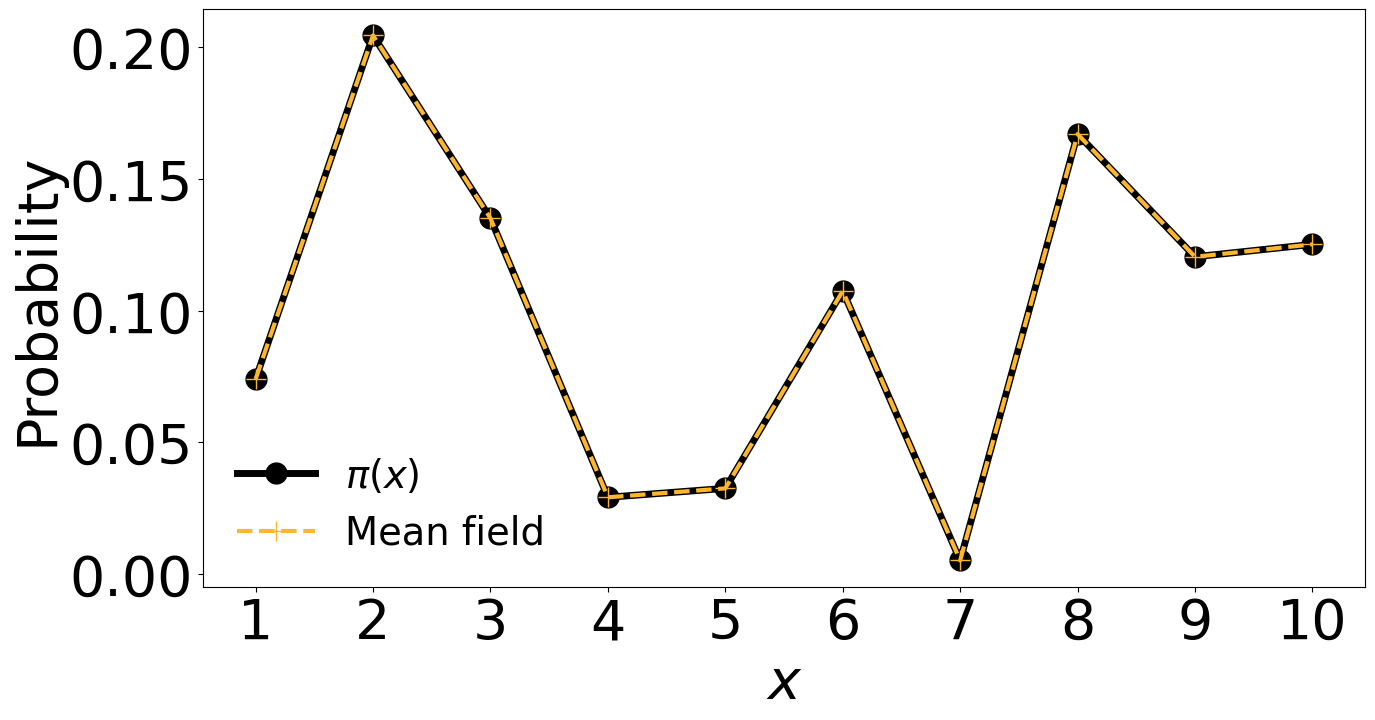

In [5]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,10)
plt.plot(ttx+0.5,prbs_onedim,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,mf_approx,c='#FEB72D', label='Mean field',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='x-small',frameon=False)
plt.xlabel(r'$x$')
plt.xticks(ticks=np.arange(0,10)+0.5,labels=np.arange(1,1+10))
plt.ylabel('Probability')

## Mean field 2D

Now we consider the case where we have a bivariate discrete target $\pi$.
We approximate $\pi$ with $q(x_1,x_2)=q_1(x_1) q_2(x_2)$,
where $q_m$ is a univariate approximation to the $m$th component of $\pi$, $i=1,2$.

We sequentially update the probabilities of $q_i$ via gradient ascent.
Specifically, we take $q_m$ to be a categorical distribution with probabilities
$(q_{mi})_{i=1}^{K_m}$ and sequentially update
$$
q_{1i}\gets\sum_{j=1}^{K_2} q_{2j}\log\pi(i,j),\quad
q_{2j}\gets\sum_{i=1}^{K_1} q_{i1}\log\pi(i,j).
$$
This update comes from updating each coordinate with the expectation w.r.t.
the other components of the log target density.

In [34]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=4
K2=5
prbs=np.random.rand(K1,K2)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    ext_lprb=np.log(np.moveaxis(np.repeat(prbs[:,:,np.newaxis],x.shape[1],axis=-1),2,0)) # stack d copies of logp vertically
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x[0,:],x[1,:]]) # for each d, return lp(x)
    if axis==0: return ext_lprb[np.arange(0,x.shape[1]),:,x[1,:]]
    if axis==1: return ext_lprb[np.arange(0,x.shape[1]),x[0,:],:]
    raise Exception("Axis out of bounds - there aren't that many variables")
prbs_twodim=np.copy(prbs)

In [47]:
p1=np.random.rand(K1)
p1/=np.sum(p1)
p2=np.random.rand(K2)
p2/=np.sum(p2)
p=p1[:,np.newaxis]*p2[np.newaxis,:]
prbs_twodim=p/np.sum(p)
print(prbs_twodim)

[[0.06733758 0.06892972 0.08340903 0.07526239 0.00934   ]
 [0.05500866 0.05630929 0.06813757 0.06148251 0.00762993]
 [0.05577605 0.05709483 0.06908812 0.06234021 0.00773637]
 [0.04318    0.04420096 0.05348577 0.04826176 0.00598925]]


In [65]:
########################
########################
#    mean field 2D     #
########################
########################
def meanfield2D(lq1,lq2,lp,max_iters):
    """
    Discrete mean field VI for 2D distributions
    
    Inputs:
        lq1       : (K1,) array, initial variational log probabilities of X1
        lq2       : (K2,) array, initial variational log probabilities of X2
        lp        : (K1,K2) array, target log probabilities
        max_iters : int, max number of gradient ascent iterations
        
    Outputs:
        lq1_ : (K1,) array, updated X1 variational log probabilities
        lq2_ : (K2,) array, updated X2 variational log probabilities
    """
    #q1=np.exp(lq1)
    #q2=np.exp(lq2)
    lq1_=np.copy(lq1)
    lq2_=np.copy(lq2)
    for t in range(max_iters):
        # update q1
        #tmp_pi=np.exp(lp)**q2[np.newaxis,:]
        #q1=np.prod(tmp_pi,axis=1)
        #q1=q1/np.sum(q1)
        lq1_=np.sum(np.exp(lq2_)[np.newaxis,:]*lp,axis=1)
        
        # update q2
        #tmp_pi=np.exp(lp)**q1[:,np.newaxis]
        #q2=np.prod(tmp_pi,axis=0)
        #q2=q2/np.sum(q2)
        lq2_=np.sum(np.exp(lq1_)[:,np.newaxis]*lp,axis=0)
    # end for
    return lq1_,lq2_

In [66]:
########################
########################
#  fit mean field 2D   #
########################
########################
lq1=np.log(1/K1)*np.ones(K1)
lq2=np.log(1/K2)*np.ones(K2)
lp=np.log(prbs_twodim)
max_iters=10
mf_approx1,mf_approx2=meanfield2D(lq1,lq2,lp,max_iters)

[0.20895455 0.20973652 0.21622702 0.21270389 0.15237803]
[0.20002261 0.20002423 0.20003748 0.20003034 0.19988534]
[0.20000003 0.20000004 0.20000006 0.20000005 0.19999983]
[0.20000003 0.20000004 0.20000005 0.20000004 0.19999983]
[0.20000003 0.20000004 0.20000005 0.20000004 0.19999983]
[0.20000003 0.20000004 0.20000005 0.20000004 0.19999983]
[0.20000003 0.20000004 0.20000005 0.20000004 0.19999983]
[0.20000003 0.20000004 0.20000005 0.20000004 0.19999983]
[0.20000003 0.20000004 0.20000005 0.20000004 0.19999983]
[0.20000003 0.20000004 0.20000005 0.20000004 0.19999983]


([<matplotlib.axis.XTick at 0x11eb916d0>,
 [Text(0.5, 0, '1'), Text(1.5, 0, '2'), Text(2.5, 0, '3'), Text(3.5, 0, '4')])

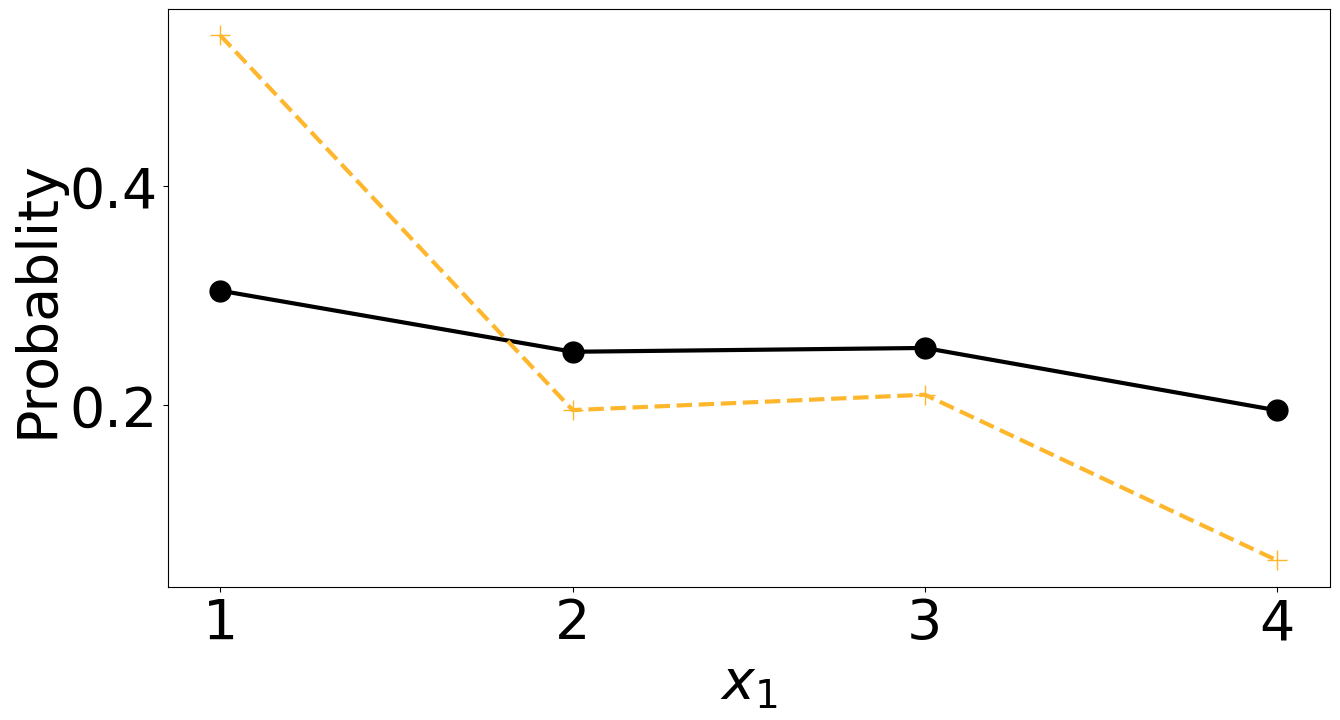

In [59]:
########################
########################
#   plot x1 results    #
########################
########################

ttx=np.arange(0,4)
plt.plot(ttx+0.5,np.sum(prbs_twodim,axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.exp(mf_approx1)/np.sum(np.exp(mf_approx1)),c='#FEB72D', label='Mean field',lw=3,ls='dashed',ms=15,marker='+')
plt.xlabel(r'$x_1$')
plt.ylabel('Probablity')
plt.xticks(ticks=np.arange(0,4)+0.5,labels=np.arange(1,1+4))

Text(0, 0.5, 'Probability')

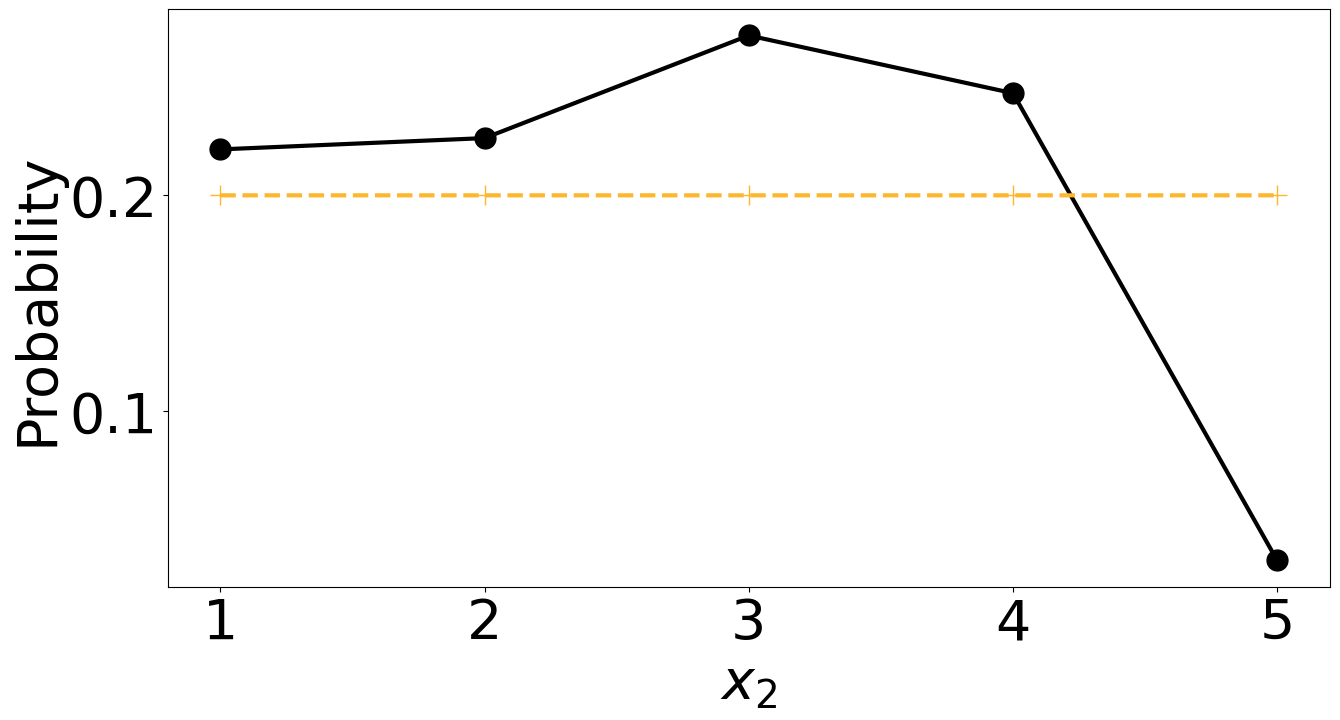

In [61]:
########################
########################
#   plot x2 results    #
########################
########################

ttx=np.arange(0,5)
plt.plot(ttx+0.5,np.sum(prbs_twodim,axis=0),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.exp(mf_approx2)/np.sum(np.exp(mf_approx2)),c='#FEB72D', label='Mean field',lw=3,ls='dashed',ms=15,marker='+')
plt.xlabel(r'$x_2$')
plt.xticks(ticks=np.arange(0,5)+0.5,labels=np.arange(1,1+5))
plt.ylabel('Probability')

## Mean field mixture

In [29]:
########################
########################
# target specification #
########################
########################
mu=np.array([4,15]) # the two modes
K1,K2=20,2
def aux_gausslp(aux): return -0.5*(np.arange(0,20)-mu[aux][:,np.newaxis])**2-0.5*np.log(2*np.pi)
def aux_gausslp_1d(y,x): return -0.5*(y-mu[x])**2-0.5*np.log(2*np.pi)

def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    y=x[0,:]
    aux=x[1,:]
    
    if axis==None: return -0.5*(y-mu[aux])**2-0.5*np.log(2*np.pi)
    if axis==0: return aux_gausslp(aux)
    if axis==1: 
        wlpy0=aux_gausslp_1d(y,0)+np.log(0.5)
        wlpy1=aux_gausslp_1d(y,1)+np.log(0.5)
        m=np.maximum(wlpy0,wlpy1)
        lpy=m+np.log(np.exp(wlpy0-m)+np.exp(wlpy1-m))
        out=np.ones((y.shape[0],2))
        out[:,0]=wlpy0
        out[:,1]=wlpy1
        return out-lpy[:,np.newaxis]
    raise Exception("Axis out of bounds - there aren't that many variables")

In [30]:
# evaluate target density
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)

mylp=np.exp(lp(x))
prbs=np.zeros((20,2))
prbs[:,0]=mylp[:20]
prbs[:,1]=mylp[20:]
prbs=prbs/np.sum(prbs)
prbs_mixture=np.copy(prbs)

In [31]:
##########################
##########################
# fit mean field mixture #
##########################
##########################
lq1=np.log(1/K1)*np.ones(K1)
lq2=np.log(1/K2)*np.ones(K2)
lp=np.log(prbs_mixture)
max_iters=10000
mf_approx1,mf_approx2=meanfield2D(lq1,lq2,lp,max_iters)

Text(0, 0.5, 'Probability')

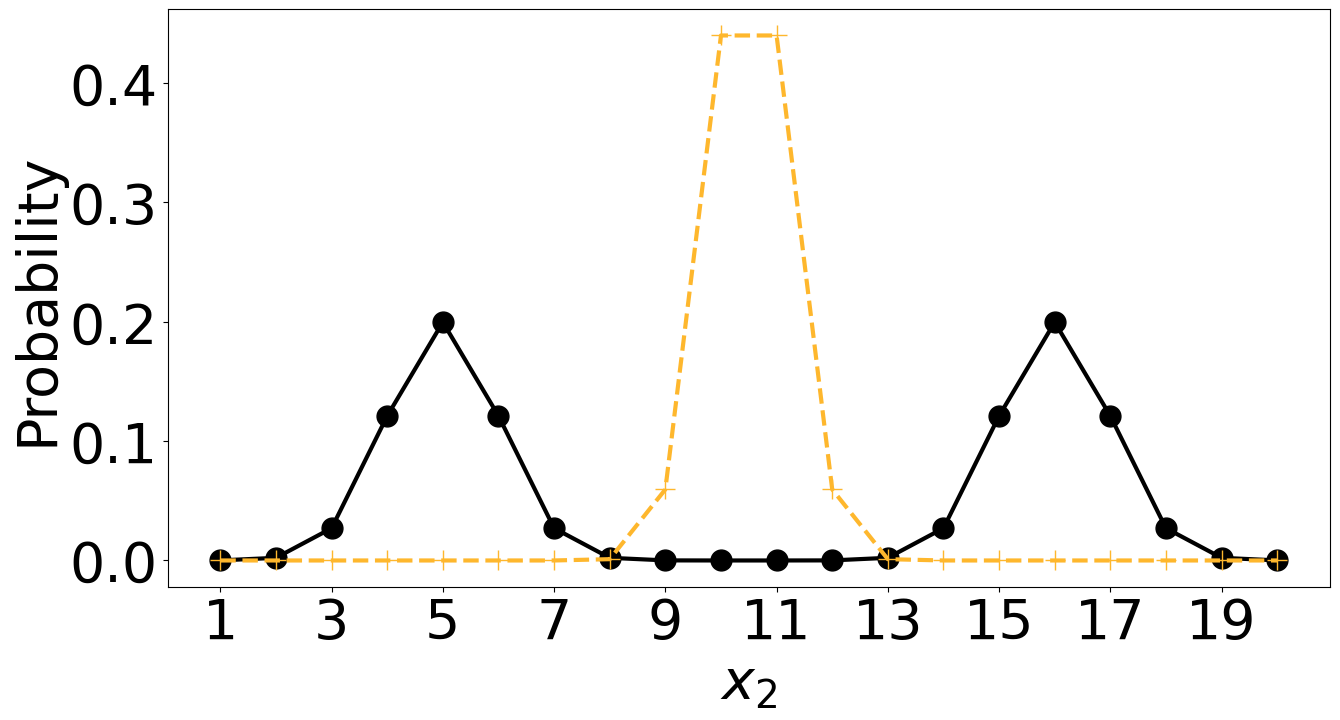

In [32]:
ttx=np.arange(0,20)
plt.plot(ttx+0.5,np.sum(prbs_mixture/np.sum(prbs_mixture),axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.exp(mf_approx1)/np.sum(np.exp(mf_approx1)),c='#FEB72D', 
         label='Mean field',lw=3,ls='dashed',ms=15,marker='+')
plt.xlabel(r'$x_2$')
plt.xticks(ticks=np.arange(0,20,step=2)+0.5,labels=np.arange(1,21,step=2))
plt.ylabel('Probability')